# Distracted drivers
### Image classification of distracted drivers
------------------------------------------------------
**Table of Contents:**
1. [Import of libraries and dataset info](#import)
2. [Dataset visualization](#visualization)
3. [Loading and splitting of dataset](#load)
4. [Data augmentation](#augmentation)
5. [Model definition and training](#training)
6. [Model evaluation](#evaluation)

### 1. Import of libraries and dataset info <a name="import"></a>

In [1]:
# Import necessary libraries
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
# Load csv file with information about dataset
dataset_path = '.\\data\\images'
data_info_path = '.\\data\\driver_imgs_list.csv'

data_info = pd.read_csv(data_info_path)
data_info.head()

subject classname            img
0    p002        c0  img_44733.jpg
1    p002        c0  img_72999.jpg
2    p002        c0  img_25094.jpg
3    p002        c0  img_69092.jpg
4    p002        c0  img_92629.jpg

In [3]:
print(f'Number of images in dataset: {len(data_info)}')

Number of images in dataset: 22424


### 2. Dataset visualization <a name="visualization"></a>

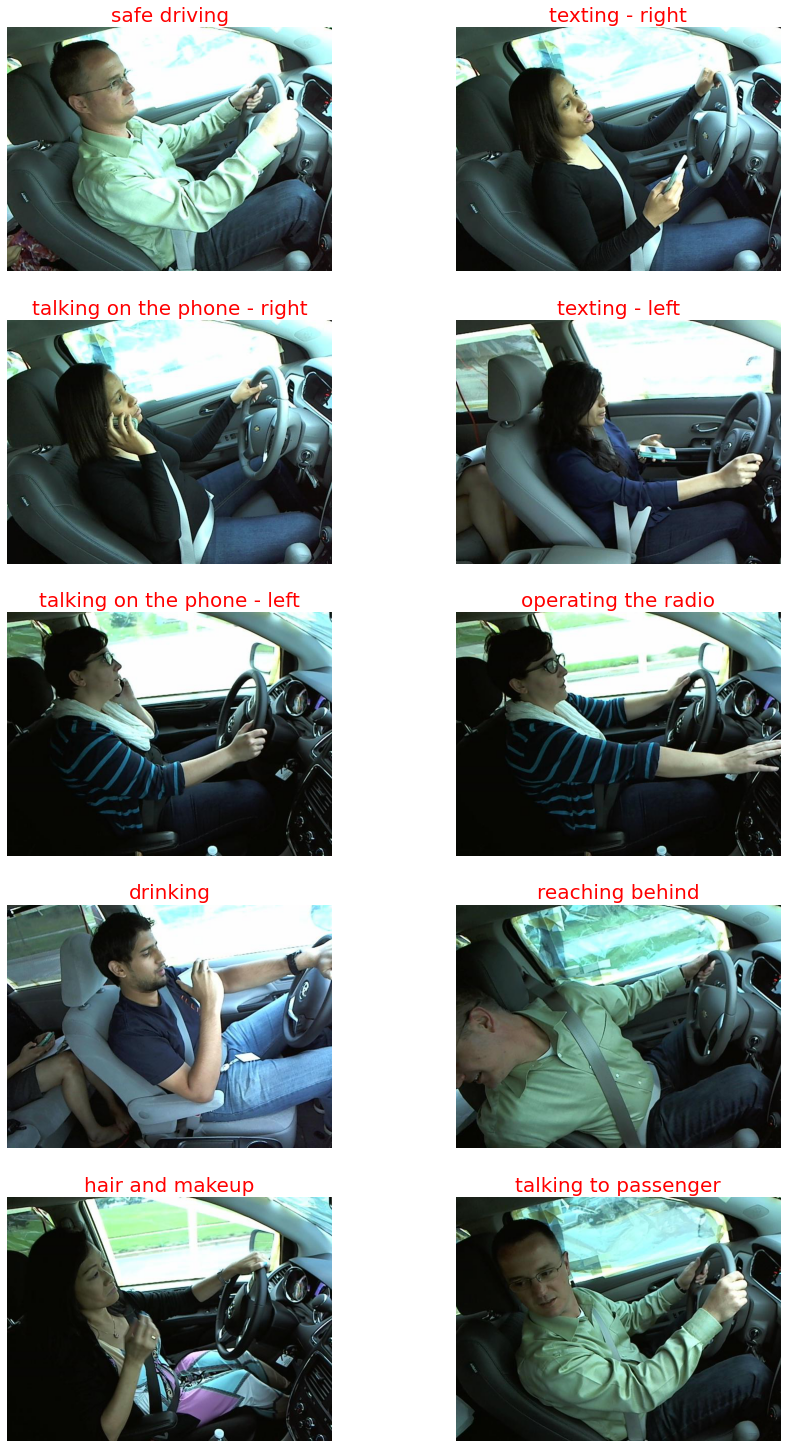

In [4]:
# Load and show sample images from each class
class_dict = {'c0': 'safe driving',
              'c1': 'texting - right',
              'c2': 'talking on the phone - right',
              'c3': 'texting - left',
              'c4': 'talking on the phone - left',
              'c5': 'operating the radio',
              'c6': 'drinking',
              'c7': 'reaching behind',
              'c8': 'hair and makeup',
              'c9': 'talking to passenger'}

plt.figure(figsize=(16, 26))

for i, class_name in enumerate(class_dict.keys()):
    
    sample = data_info[data_info['classname'] == class_name].sample()
    img_name = sample['img'].values[0]
    img_path = os.path.join(dataset_path, class_name, img_name)
    img = mpimg.imread(img_path)
    
    plt.subplot(5, 2, i+1)
    plt.imshow(img)
    plt.title(class_dict[class_name], fontdict={'color': 'red', 'fontsize': 20})
    plt.axis("off")
    
plt.subplots_adjust(hspace=0.2, wspace=0.01)
plt.show()

In [5]:
# Show class distribution in dataset
class_count = data_info.groupby('classname').size()
class_count = class_count.rename(index=class_dict)
fig = px.bar(y=class_count.index, x=class_count, labels={'y': 'Class', 'x': 'Counts'},
             title='Number of images in each class', template='seaborn', orientation='h')
fig.show()

In [6]:
# Show drivers distribution in dataset
driver_counts = data_info['subject'].value_counts()
fig = px.bar(x=driver_counts.index, y=driver_counts, labels={'y': 'Counts', 'x': 'Driver ID'},
             title='Number of images per driver', template='seaborn')
fig.show()

### 3. Loading and splitting of dataset <a name="load"></a>

In [7]:
# Load images and labels, perform one-hot-encoding on labels
img_width = 128
img_height = 128

def load_dataset(path, width, height):
    images = []
    labels = []
    
    for class_dir in os.listdir(path):
        class_path = os.path.join(path, class_dir)
        label = int(class_dir[-1])
        
        for file_name in os.listdir(class_path):
            file_path = os.path.join(class_path, file_name)
            img = cv2.imread(file_path, cv2.IMREAD_COLOR)
            img = cv2.resize(img, (width, height))
            images.append(img)
            labels.append(label)
            
    return np.array(images, dtype=np.uint8), np.array(labels, dtype=np.uint8)

X, y = load_dataset(dataset_path, img_width, img_height)
y = to_categorical(y, 10)
print(f'Images shape: {X.shape}')
print(f'Labels shape: {y.shape}')

Images shape: (22424, 128, 128, 3)
Labels shape: (22424, 10)


In [8]:
# Split dataset to train, validation and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
print(f'Train set size: {len(X_train)}')
print(f'Validation set size: {len(X_val)}')
print(f'Test set size: {len(X_test)}')

Train set size: 14351
Validation set size: 3588
Test set size: 4485


### 4. Data augmentation <a name="augmentation"></a>

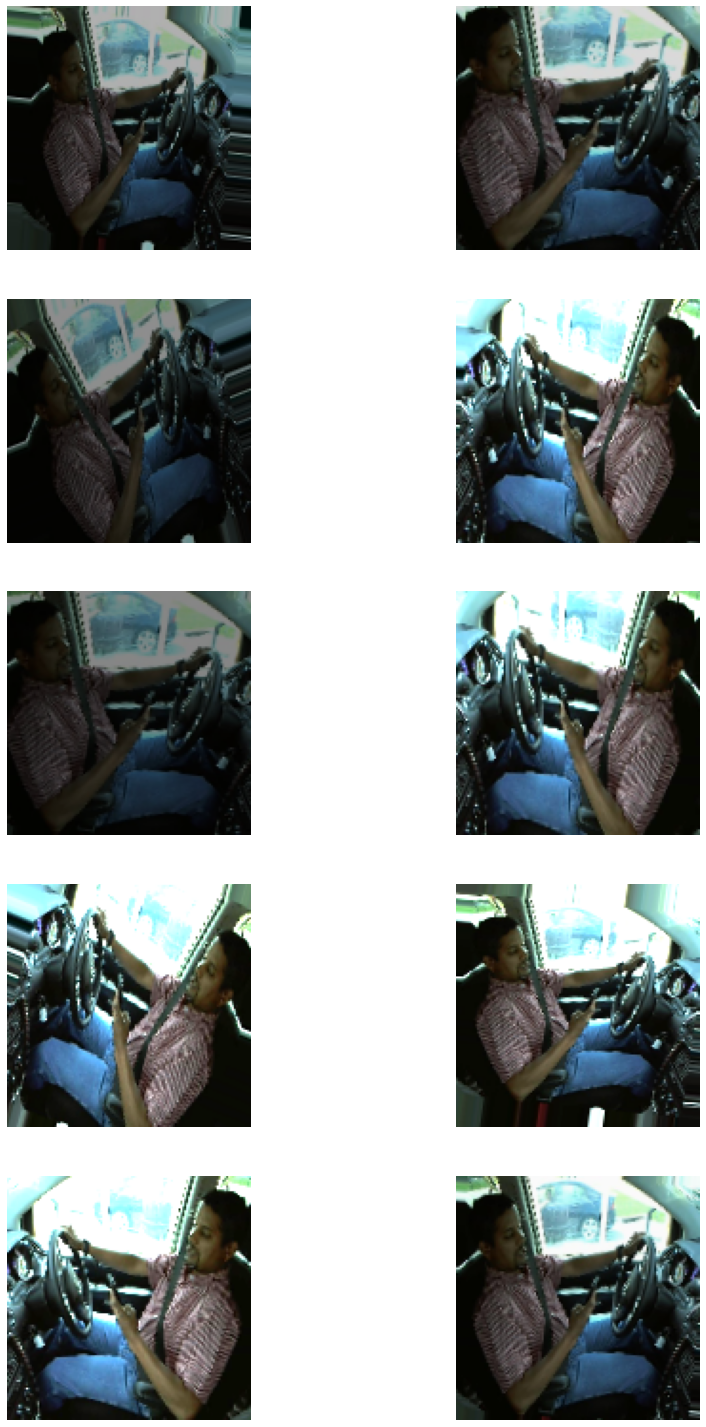

In [9]:
# Prepare and show augmentation transformations
train_datagen = ImageDataGenerator(rescale=1./255.,
                                     horizontal_flip=True,
                                     zoom_range=0.2,
                                     rotation_range=20,
                                     brightness_range=[0.5, 2.])
test_datagen = ImageDataGenerator(rescale=1./255.)

random_idx = np.random.randint(0, len(X_train), size=1)
iterator = train_datagen.flow(X_train[random_idx], batch_size=1)
plt.figure(figsize=(16, 26))

for i in range(10):
    batch = iterator.next()
    img = batch[0] * 255
    img = img.astype(np.uint8)
    plt.subplot(5, 2, i+1)
    plt.imshow(img[:, :, ::-1])
    plt.axis("off")

plt.subplots_adjust(hspace=0.2, wspace=0.01)
plt.show()

In [10]:
train_samples = len(X_train)
val_samples = len(X_val)
batch_size = 32

train_generator = train_datagen.flow(X_train, y_train, batch_size=batch_size, seed=42)
val_generator = test_datagen.flow(X_val, y_val, batch_size=batch_size, seed=42)

### 5. Model definition and training <a name="training"></a>

In [11]:
# Define CNN architecture
model = Sequential()
model.add(Conv2D(filters=32, kernel_size=2, padding='same', activation='relu',
                 input_shape=(128, 128, 3)))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=64, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=128, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=256, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=512, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 32)      416       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 64)        8256      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 128)       32896     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 16, 16, 128)      0

In [12]:
# Prepare and fit model
checkpoint_file = 'best_model.h5'
steps_per_epoch = train_samples // batch_size
validation_steps = val_samples // batch_size

checkpoint_cb = ModelCheckpoint(checkpoint_file, monitor='val_accuracy', save_best_only=True)
early_stopping_cb = EarlyStopping(patience=10, restore_best_weights=True)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(train_generator,
                    epochs=100,
                    steps_per_epoch=steps_per_epoch,
                    validation_data=val_generator,
                    validation_steps=validation_steps,
                    callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/100
448/448 [==============================] - 46s 89ms/step - loss: 2.1871 - accuracy: 0.1716 - val_loss: 1.6699 - val_accuracy: 0.3987
Epoch 2/100
448/448 [==============================] - 40s 89ms/step - loss: 1.4969 - accuracy: 0.4315 - val_loss: 1.0416 - val_accuracy: 0.5979
Epoch 3/100
448/448 [==============================] - 40s 89ms/step - loss: 1.1035 - accuracy: 0.5969 - val_loss: 0.7452 - val_accuracy: 0.7341
Epoch 4/100
448/448 [==============================] - 40s 90ms/step - loss: 0.8148 - accuracy: 0.7118 - val_loss: 0.4729 - val_accuracy: 0.8443
Epoch 5/100
448/448 [==============================] - 40s 88ms/step - loss: 0.6439 - accuracy: 0.7794 - val_loss: 0.4161 - val_accuracy: 0.8719
Epoch 6/100
448/448 [==============================] - 41s 91ms/step - loss: 0.5521 - accuracy: 0.8104 - val_loss: 0.2557 - val_accuracy: 0.9252
Epoch 7/100
448/448 [==============================] - 41s 91ms/step - loss: 0.4934 - accuracy: 0.8346 - val_loss: 0.3186 - val_ac

In [13]:
# Show model learning process
def plot_hist(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    fig = go.Figure()
    fig.add_trace(go.Scatter(x=hist['epoch'], y=hist['accuracy'], name='training', mode='markers+lines'))
    fig.add_trace(go.Scatter(x=hist['epoch'], y=hist['val_accuracy'],
                             name='validation', mode='markers+lines'))
    fig.update_layout(xaxis_title='Epoch', yaxis_title='Accuracy', title={'text': 'Model accuracy',
                                                                          'x': 0.5})
    fig.show()

    fig = go.Figure()
    fig.add_trace(go.Scatter(x=hist['epoch'], y=hist['loss'], name='training', mode='markers+lines'))
    fig.add_trace(go.Scatter(x=hist['epoch'], y=hist['val_loss'], name='validation', mode='markers+lines'))
    fig.update_layout(xaxis_title='Epoch', yaxis_title='Loss', title={'text': 'Model loss',
                                                                      'x': 0.5})
    fig.show()

plot_hist(history)

### 6. Model evaluation <a name="evaluation"></a>

In [14]:
# Evaluate model on the test set
X_test = X_test / 255.

score = model.evaluate(X_test, y_test)
loss = score[0]
accuracy = score[1]
print(f'Loss on the test set: {loss:.3f}')
print(f'Accuracy on the test set: {accuracy*100:.3f}%')

141/141 [==============================] - 1s 9ms/step - loss: 0.0667 - accuracy: 0.9822
Loss on the test set: 0.067
Accuracy on the test set: 98.216%


In [15]:
# Predict labels of the test set and show classification report
class_dict = {0: 'safe driving',
              1: 'texting - right',
              2: 'talking on the phone - right',
              3: 'texting - left',
              4: 'talking on the phone - left',
              5: 'operating the radio',
              6: 'drinking',
              7: 'reaching behind',
              8: 'hair and makeup',
              9: 'talking to passenger'}
labels = list(class_dict.values())

y_true = y_test.argmax(axis=1)
y_pred = model.predict(X_test).argmax(axis=1)
report = classification_report(y_true, y_pred, target_names=labels)
print(report)

                              precision    recall  f1-score   support

                safe driving       0.96      0.98      0.97       463
             texting - right       0.99      0.99      0.99       500
talking on the phone - right       0.98      1.00      0.99       480
              texting - left       0.99      0.99      0.99       491
 talking on the phone - left       0.99      1.00      0.99       466
         operating the radio       1.00      0.99      0.99       466
                    drinking       0.99      0.98      0.98       457
             reaching behind       0.99      0.99      0.99       377
             hair and makeup       0.99      0.92      0.96       390
        talking to passenger       0.94      0.96      0.95       395

                    accuracy                           0.98      4485
                   macro avg       0.98      0.98      0.98      4485
                weighted avg       0.98      0.98      0.98      4485



In [16]:
# Show confusion matrix
def plot_confusion_matrix(cm, labels, accuracy):
    cm = cm[::-1]
    fig = ff.create_annotated_heatmap(z=cm, x=labels, y=labels[::-1], colorscale='ice', reversescale=True)
    fig.update_layout(yaxis_title='True label', xaxis_title='Predicted label',
                      yaxis=dict(tickfont=dict(size=10)), xaxis=dict(tickfont=dict(size=10)),
                      title={'text': f'Model accuracy: {accuracy*100:.3f}%', 'x': 0.5, 'y': 0.05})
    fig.show()

cm = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(cm, labels, accuracy)

In [17]:
results = pd.DataFrame(data=dict(y_true=y_true, y_pred=y_pred))
results['error'] = (results['y_true'] != results['y_pred']) * 1
print(f'Number of misclassified images: {results["error"].sum()}')

Number of misclassified images: 80


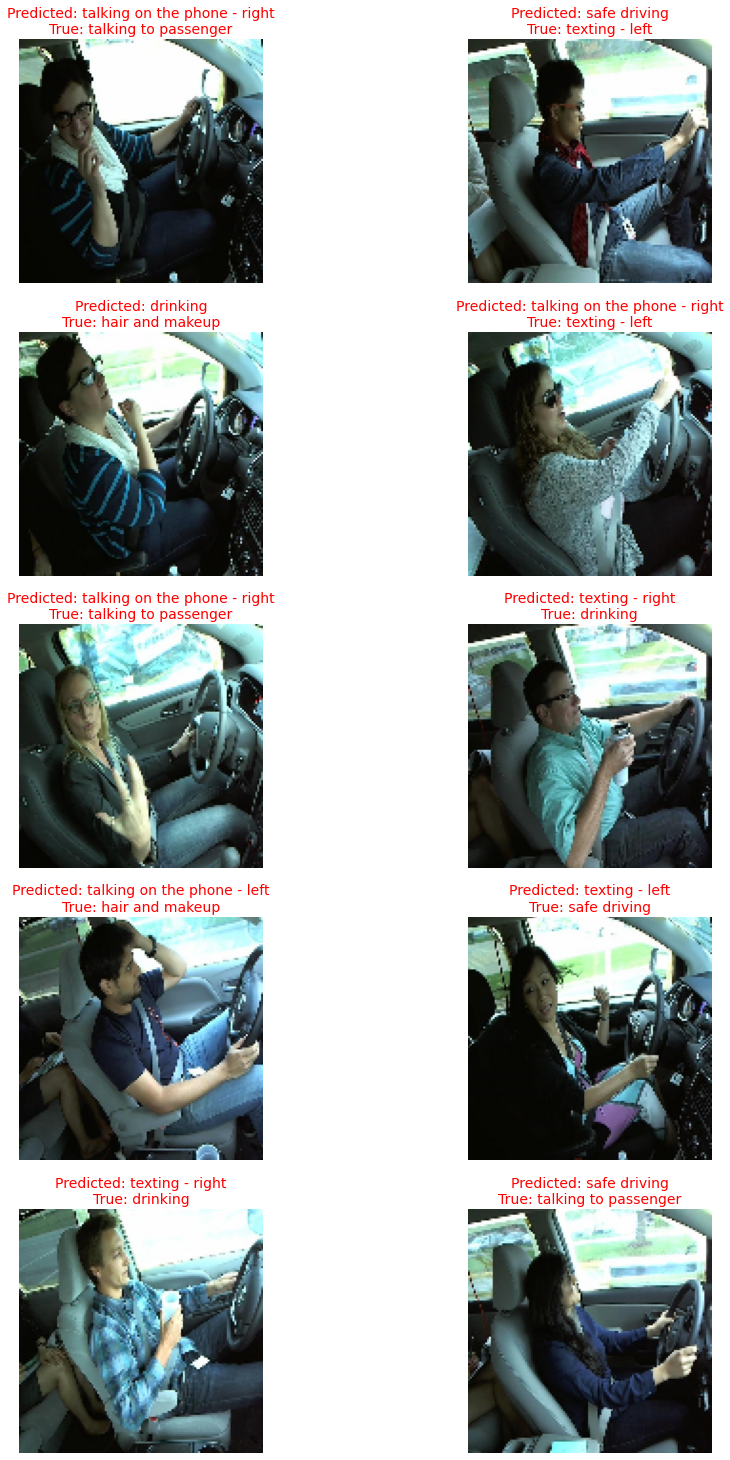

In [20]:
# Show sample misclassified images
errors_idxs = results[results['error'] == 1].index.values
random_idxs = np.random.choice(errors_idxs, size=10, replace=False)
plt.figure(figsize=(16, 26))

for i, idx in enumerate(random_idxs):
    y_t = class_dict[y_true[idx]]
    y_p = class_dict[y_pred[idx]]
    img = X_test[idx] * 255
    img = img.astype(np.uint8)
    plt.subplot(5, 2, i+1)
    plt.imshow(img[:, :, ::-1])
    plt.title(label=f'Predicted: {y_p}\nTrue: {y_t}', fontdict={'color': 'red', 'fontsize': 14})
    plt.axis("off")

plt.subplots_adjust(hspace=0.2, wspace=0.01)
plt.show()